### This notebook loads a Sentinel-1 data product with the xarray package and calibrates both image channels (HH and HV) using the Look-Up Table for Sigma Nought. Results are visualized using the Cartopy module.

In [1]:
# imports
import os
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
## Open Sentinel-1 product

In [3]:
# open S1 image via xarray
s1 = xr.open_dataset('https://nbstds.met.no/thredds/dodsC/NBS/S1A/2023/01/19/EW/S1A_EW_GRDM_1SDH_20230119T080256_20230119T080356_046850_059E12_D79F.nc')
s1

<xarray.Dataset>
Dimensions:                      (time: 1, y: 9992, x: 10493, gcp_index: 441)
Coordinates:
  * time                         (time) datetime64[ns] 2023-01-19T08:02:56
    lat                          (y, x) float32 ...
    lon                          (y, x) float32 ...
Dimensions without coordinates: y, x, gcp_index
Data variables: (12/40)
    Amplitude_HH                 (time, y, x) float32 ...
    Amplitude_HV                 (time, y, x) float32 ...
    crsWGS84                     int32 ...
    sigmaNought_HH               (time, y, x) float32 ...
    betaNought_HH                (time, y, x) float32 ...
    gamma_HH                     (time, y, x) float32 ...
    ...                           ...
    orbitList_HH                 int8 ...
    coordinateConversionList_HH  int8 ...
    swathMergeList_HH            int8 ...
    orbitList_HV                 int8 ...
    coordinateConversionList_HV  int8 ...
    swathMergeList_HV            int8 ...
Attributes: (12/70)
    BEAM_MODE:                        EW
    BEAM_SWATH:                       EW
    FACILITY_IDENTIFIER:              Copernicus Ground Segment
    LINE_SPACING:                     4.000000e+01
    MISSION_ID:                       S1A
    PIXEL_SPACING:                    4.000000e+01
    ...                               ...
    time_coverage_end:                2023-01-19T08:03:56.042623Z
    mode:                             EW
    geospatial_lon_min:               -21.691023
    geospatial_lat_min:               74.64547
    geospatial_lon_max:               -0.304568
    geospatial_lat_max:               79.349464

In [5]:
scene_name = s1.attrs['title']
scene_name

# extract extent of image (upper left corner, lower right corner) in geodetic coordinates
lon_min_geo = s1.attrs['geospatial_lon_min']
lat_min_geo = s1.attrs['geospatial_lat_min']
lon_max_geo = s1.attrs['geospatial_lon_max']
lat_max_geo = s1.attrs['geospatial_lat_max']
print('Image extent (lon_min, lon_max, lat_min,lat_max) is: ', lon_min_geo, lon_max_geo, lat_min_geo, lat_max_geo, 'degrees')

Image extent (lon_min, lon_max, lat_min,lat_max) is:  -21.691023 -0.304568 74.64547 79.349464 degrees


## Plot amplitude values of HH channel

In [6]:
# plotting with all values is slow, so use only every 5th value
stride = 5

image = s1["Amplitude_HH"][0,::stride,::stride]
lon = s1['lon'][::stride,::stride]
lat = s1['lat'][::stride,::stride]

# vmin, vmax are the 2nd and 98th percentile in the image data, this increases contrast when plotting the S1 image
vmin = np.nanpercentile(image, 2)
vmax = np.nanpercentile(image, 98)

Text(0.5, 1.0, 'S1A_EW_GRDM_1SDH_20230119T080256_20230119T080356_046850_059E12_D79F')

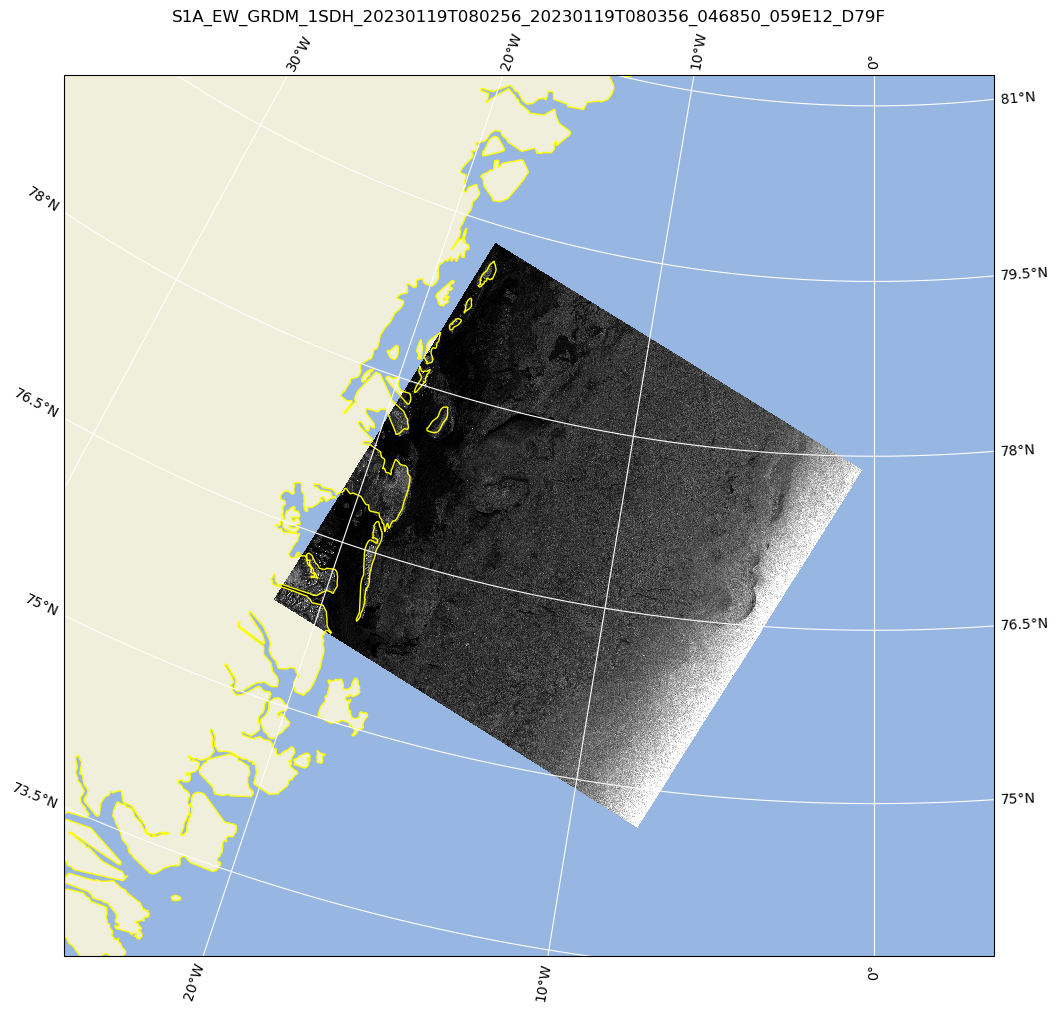

In [22]:
# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

# create a figure handle
fig = plt.figure(figsize=(12,12))

# create an axes handle with the previously specified projection
ax = plt.axes(projection=target_projection)

# customise map and add features
ax.set_extent([lon_min_geo - 4,lon_max_geo + 4, lat_min_geo - 1, lat_max_geo + 1])
plt.pcolormesh(lon, lat, image, transform=orig_projection, cmap='gray', vmin=vmin, vmax=vmax)

ax.gridlines(color='white',draw_labels=True, y_inline=False)
ax.coastlines(color='yellow')
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.set_title('Amplitude values of HH channel')

## Radiometric calibration of the image
Calibrate image channels to obtain sigma nought backscatter values, then convert to dB

In [4]:
# grab digital numbers
dn_HH = s1['Amplitude_HH']
dn_HV = s1['Amplitude_HV']

# grab Look-Up-Table (LUT) for sigma nought
lut_HH = s1['sigmaNought_HH']
lut_HV = s1['sigmaNought_HV']

# calculate sigma nought values
sigma_n_HH = dn_HH**2 / lut_HH**2
sigma_n_HV = dn_HV**2 / lut_HV**2

# convert to dB
sigma_n_HH_db = 10*np.log10(sigma_n_HH)
sigma_n_HV_db = 10*np.log10(sigma_n_HV)

## Plot calibrated HH channel

Text(0.5, 1.0, 'S1A_EW_GRDM_1SDH_20230119T080256_20230119T080356_046850_059E12_D79F')

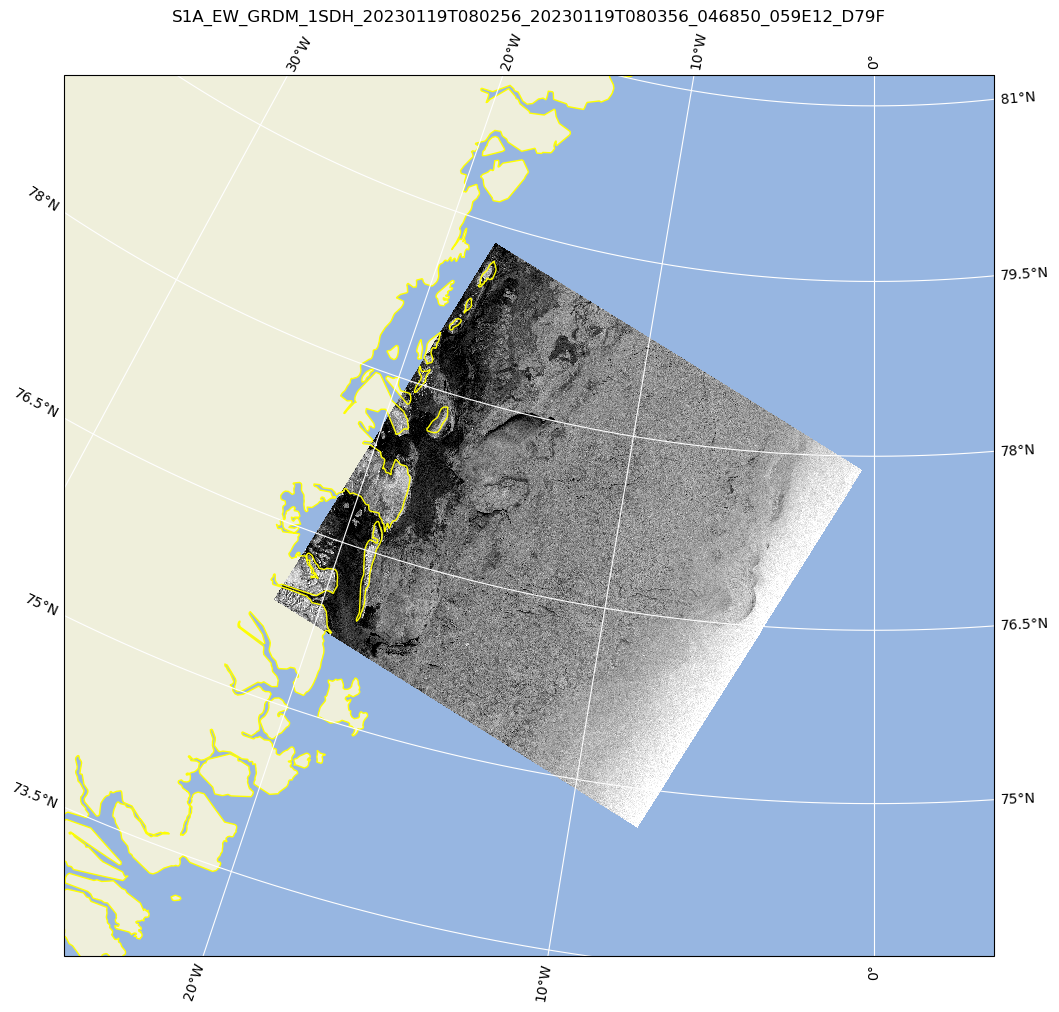

In [7]:
# plot calibrated image
stride = 5

image = sigma_n_HH_db[0,::stride,::stride]
lon = s1['lon'][::stride,::stride]
lat = s1['lat'][::stride,::stride]

# vmin, vmax are the 2nd and 98th percentile in the image data, this increases contrast when plotting the S1 image
vmin = np.nanpercentile(image, 2)
vmax = np.nanpercentile(image, 98)

# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

# create a figure handle
fig = plt.figure(figsize=(12,12))

# create an axes handle with the previously specified projection
ax = plt.axes(projection=target_projection)

# customise map and add features
ax.set_extent([lon_min_geo - 4,lon_max_geo + 4, lat_min_geo - 1, lat_max_geo + 1])
plt.pcolormesh(lon, lat, image, transform=orig_projection, cmap='gray', vmin=vmin, vmax=vmax)

ax.gridlines(color='white',draw_labels=True, y_inline=False)
ax.coastlines(color='yellow')
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.set_title('Sigma Nought backscatter values of HH channel')